In [4]:
# Create a summary of available columns per cycle
column_audit = full_data.groupby('Cycle_Year').apply(lambda x: x.columns.tolist())

# Let's search for our specific categories across all years
search_terms = ['BMX', 'BPX', 'LBX', 'LBD', 'SMQ', 'PAQ', 'MCQ']

for year, cols in column_audit.items():
    print(f"\n--- Cycle: {year} ---")
    for term in search_terms:
        # Find all columns that start with or contain our key codes
        matches = [c for c in cols if term in c]
        print(f"{term} matches: {matches}")


--- Cycle: 1999-2000 ---
BMX matches: []
BPX matches: []
LBX matches: []
LBD matches: []
SMQ matches: []
PAQ matches: []
MCQ matches: ['MCQ010', 'MCQ020', 'MCQ030', 'MCQ040', 'MCQ050', 'MCQ053', 'MCQ060', 'MCQ080', 'MCQ083', 'MCQ090', 'MCQ092', 'MCQ100', 'MCQ110', 'MCQ114', 'MCQ117Q', 'MCQ117U', 'MCQ120A', 'MCQ120B', 'MCQ120C', 'MCQ120D', 'MCQ140', 'MCQ147', 'MCQ148', 'MCQ150G', 'MCQ150Q', 'MCQ160A', 'MCQ160B', 'MCQ160C', 'MCQ160D', 'MCQ160G', 'MCQ160H', 'MCQ160I', 'MCQ160J', 'MCQ160K', 'MCQ160L', 'MCQ170H', 'MCQ170I', 'MCQ170K', 'MCQ170L', 'MCQ180A', 'MCQ180B', 'MCQ180C', 'MCQ180D', 'MCQ180E', 'MCQ180F', 'MCQ180G', 'MCQ180H', 'MCQ180I', 'MCQ180K', 'MCQ180L', 'MCQ190', 'MCQ200', 'MCQ210', 'MCQ220', 'MCQ230A', 'MCQ230B', 'MCQ230C', 'MCQ230D', 'MCQ240A', 'MCQ240B', 'MCQ240C', 'MCQ240D', 'MCQ240E', 'MCQ240F', 'MCQ240G', 'MCQ240H', 'MCQ240I', 'MCQ240J', 'MCQ240K', 'MCQ240L', 'MCQ240M', 'MCQ240N', 'MCQ240O', 'MCQ240P', 'MCQ240Q', 'MCQ240R', 'MCQ240S', 'MCQ240T', 'MCQ240U', 'MCQ240V', 'MCQ2

/var/folders/25/7x2sl8tx35993bz992w_0kqc0000gn/T/ipykernel_7717/4255596047.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  column_audit = full_data.groupby('Cycle_Year').apply(lambda x: x.columns.tolist())


In [5]:
import pandas as pd
import glob

cycles = ['1999-2000', '2001-2002', '2003-2004', '2005-2006', '2007-2008', 
          '2009-2010', '2011-2012', '2013-2014', '2015-2016', 
          '2017-2020prepandemic', '2021-2023']

master_list = []

for year in cycles:
    print(f"Processing Year: {year}")
    file_list = glob.glob(f"{year}_*.xpt")
    
    if not file_list:
        continue
        
    # 1. Start with the first file (usually demo)
    df_year = pd.read_sas(file_list[0])
    
    # 2. Merge every other file
    for file in file_list[1:]:
        temp_df = pd.read_sas(file)
        
        if 'SEQN' in temp_df.columns:
            # DROP columns that are already in df_year (except SEQN)
            # This prevents the 'WTPH2YR_x' duplicate error
            cols_to_use = temp_df.columns.difference(df_year.columns.difference(['SEQN']))
            
            df_year = pd.merge(df_year, temp_df[cols_to_use], on='SEQN', how='outer')
    
    df_year['Cycle_Year'] = year
    master_list.append(df_year)

# Final Vertical Stack
full_data = pd.concat(master_list, axis=0, ignore_index=True)
print("Successfully merged! Shape:", full_data.shape)

Processing Year: 1999-2000
Processing Year: 2001-2002
Processing Year: 2003-2004
Processing Year: 2005-2006
Processing Year: 2007-2008
Processing Year: 2009-2010
Processing Year: 2011-2012
Processing Year: 2013-2014
Processing Year: 2015-2016
Processing Year: 2017-2020prepandemic
Processing Year: 2021-2023
Successfully merged! Shape: (119555, 785)


In [6]:
# Create a robust mapping for the features we've gathered
mapping = {
    # Target Variables (Medical Conditions)
    'MCQ160E': 'target_heart_attack',
    'MCQ160F': 'target_stroke',
    
    # Demographic/Identity
    'RIAGENDR': 'demo_gender',
    'RIDAGEYR': 'demo_age',
    
    # Clinical Features
    'BMXBMI':  'feat_bmi',
    'BPXSY1':  'feat_systolic_bp',
    'BPXDI1':  'feat_diastolic_bp',
    
    # Laboratory Features (Unifying shifts across years)
    'LBXTC':   'feat_total_cholesterol',
    'LBDHDL':  'feat_hdl',  # Older cycles
    'LBDHDD':  'feat_hdl',  # Newer cycles
    'LBXGH':   'feat_glyco_hemoglobin',
    'LBXCRP':  'feat_crp',  # From Standard Bio Profile
    'HSCRP_L': 'feat_crp',  # Standalone post-pandemic
    
    # Lifestyle Features
    'SMQ020':  'feat_ever_smoked',
    'PAQ670':  'feat_sedentary_mins'
}

# Rename and Subset to keep only the features we need
df_model = full_data.rename(columns=mapping)

# List of final columns to keep
final_cols = ['Cycle_Year', 'SEQN', 'demo_gender', 'demo_age'] + \
             [v for v in mapping.values() if v.startswith('feat_') or v.startswith('target_')]

df_model = df_model[final_cols]
print("Harmonized Dataset Shape:", df_model.shape)

Harmonized Dataset Shape: (119555, 19)


In [9]:
# Identify all duplicate feature columns
for feature in ['feat_hdl', 'feat_crp', 'feat_sedentary_mins']:
    # Find all columns that start with this feature name (e.g., feat_hdl_x, feat_hdl_y)
    cols = [c for c in df_final.columns if c.startswith(feature)]
    if len(cols) > 1:
        # Fill the first column with values from the others, then drop the duplicates
        df_final[feature] = df_final[cols].bfill(axis=1).iloc[:, 0]
        df_final.drop(columns=[c for c in cols if c != feature], inplace=True)

# Re-run your missing check to see the improvement!
print(df_final.isnull().mean() * 100)

Cycle_Year                 0.000000
SEQN                       0.000000
demo_gender                0.000000
demo_age                   0.000000
target_heart_attack        0.000000
target_stroke              0.000000
feat_bmi                   9.052698
feat_systolic_bp          36.420199
feat_diastolic_bp         36.420199
feat_total_cholesterol    13.379433
feat_hdl                  20.112085
feat_hdl                  20.112085
feat_hdl                  20.112085
feat_hdl                  20.112085
feat_glyco_hemoglobin     11.963301
feat_crp                  56.544337
feat_crp                  56.544337
feat_ever_smoked           0.030130
feat_sedentary_mins       77.204797
y_cvd                      0.000000
dtype: float64


/var/folders/25/7x2sl8tx35993bz992w_0kqc0000gn/T/ipykernel_7717/3468955448.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[feature] = df_final[cols].bfill(axis=1).iloc[:, 0]
/var/folders/25/7x2sl8tx35993bz992w_0kqc0000gn/T/ipykernel_7717/3468955448.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.drop(columns=[c for c in cols if c != feature], inplace=True)
/var/folders/25/7x2sl8tx35993bz992w_0kqc0000gn/T/ipykernel_7717/3468955448.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [10]:
# 1. Combine columns with duplicate names by taking the first non-null value
df_final = df_final.groupby(lambda x: x, axis=1).first()

# 2. Convert Gender to Binary (0 = Female, 1 = Male) 
# NHANES: 1=Male, 2=Female.
df_final['demo_gender'] = df_final['demo_gender'].map({1: 1, 2: 0})

# 3. Check the missing percentages again
print("Cleaned Missing Stats:\n", df_final.isnull().mean() * 100)

/var/folders/25/7x2sl8tx35993bz992w_0kqc0000gn/T/ipykernel_7717/146396568.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_final = df_final.groupby(lambda x: x, axis=1).first()


Cleaned Missing Stats:
 Cycle_Year                 0.000000
SEQN                       0.000000
demo_age                   0.000000
demo_gender                0.000000
feat_bmi                   9.052698
feat_crp                  56.544337
feat_diastolic_bp         36.420199
feat_ever_smoked           0.030130
feat_glyco_hemoglobin     11.963301
feat_hdl                  20.112085
feat_sedentary_mins       77.204797
feat_systolic_bp          36.420199
feat_total_cholesterol    13.379433
target_heart_attack        0.000000
target_stroke              0.000000
y_cvd                      0.000000
dtype: float64


In [11]:
from sklearn.impute import KNNImputer

# 1. Drop features that are too sparse
df_final = df_final.drop(columns=['feat_sedentary_mins']) # 77% is too high

# 2. Separate Features and Target
features = [col for col in df_final.columns if col.startswith('feat_') or col.startswith('demo_')]
X = df_final[features]
y = df_final['y_cvd']
years = df_final['Cycle_Year']

# 3. KNN Imputation (Fills gaps based on similar participants)
# We use a small n_neighbors for medical data
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 4. Chronological Split
# Training: 1999 to 2018
train_mask = years.str.contains('1999|2001|2003|2005|2007|2009|2011|2013|2015|2017')
X_train = X_imputed[train_mask.values]
y_train = y[train_mask.values]

# Test (Validation): 2021-2023
test_mask = years.str.contains('2021-2023')
X_test = X_imputed[test_mask.values]
y_test = y[test_mask.values]

print(f"Training set: {X_train.shape[0]} rows | Test set: {X_test.shape[0]} rows")

Training set: 58596 rows | Test set: 7782 rows


--- Validation Report (2021-2023) ---
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79      7148
         1.0       0.17      0.78      0.29       634

    accuracy                           0.68      7782
   macro avg       0.57      0.73      0.54      7782
weighted avg       0.91      0.68      0.75      7782



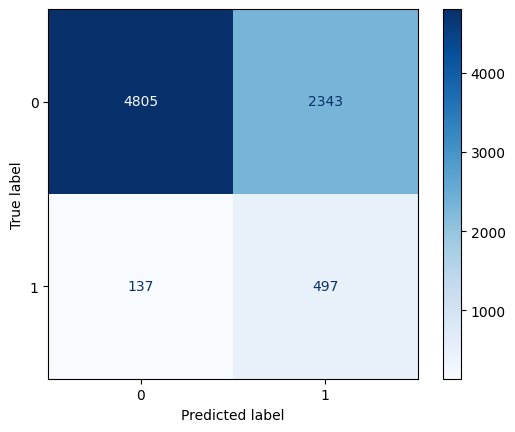

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Initialize the Model
# class_weight='balanced' is crucial because CVD is only ~8% of your data
rf_model = RandomForestClassifier(n_estimators=100, 
                                  max_depth=10, 
                                  class_weight='balanced', 
                                  random_state=42)

# 2. Train on the 1999-2018 data
rf_model.fit(X_train, y_train)

# 3. Predict on the 2021-2023 "Post-Pandemic" set
y_pred = rf_model.predict(X_test)

# 4. Evaluate Performance
print("--- Validation Report (2021-2023) ---")
print(classification_report(y_test, y_pred))

# Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

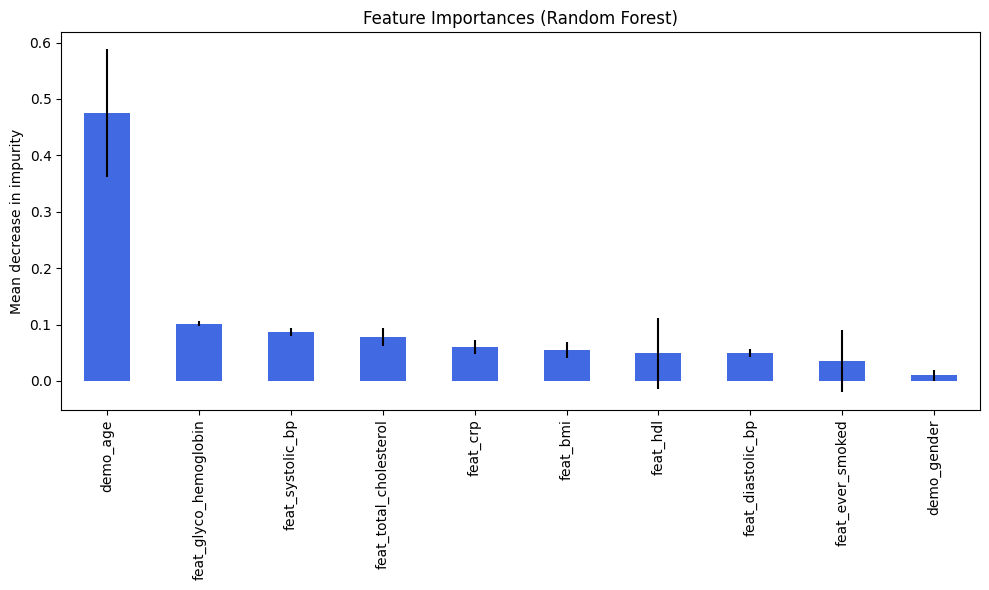

In [13]:
import numpy as np

# Extract feature importance
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns)

# Plotting
plt.figure(figsize=(10,6))
forest_importances.sort_values(ascending=False).plot.bar(yerr=std, color='royalblue')
plt.title("Feature Importances (Random Forest)")
plt.ylabel("Mean decrease in impurity")
plt.tight_layout()
plt.show()

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# 1. Initialize XGBoost
# scale_pos_weight is approximately (Negative Count / Positive Count)
# In your data: (0.92 / 0.08) is roughly 11
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=11, 
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 2. Train on 1999-2018 data
xgb_model.fit(X_train, y_train)

# 3. Predict Probabilities (Better for AUC)
y_prob = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb_model.predict(X_test)

# 4. Evaluation
print("--- XGBoost Validation Report (2021-2023) ---")
print(classification_report(y_test, y_pred_xgb))
print(f"XGBoost AUC-ROC Score: {roc_auc_score(y_test, y_prob):.4f}")

--- XGBoost Validation Report (2021-2023) ---
              precision    recall  f1-score   support

         0.0       0.97      0.66      0.78      7148
         1.0       0.17      0.80      0.28       634

    accuracy                           0.67      7782
   macro avg       0.57      0.73      0.53      7782
weighted avg       0.91      0.67      0.74      7782

XGBoost AUC-ROC Score: 0.7937


/Users/deeptiagrawal/anaconda3/envs/globalenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:11:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


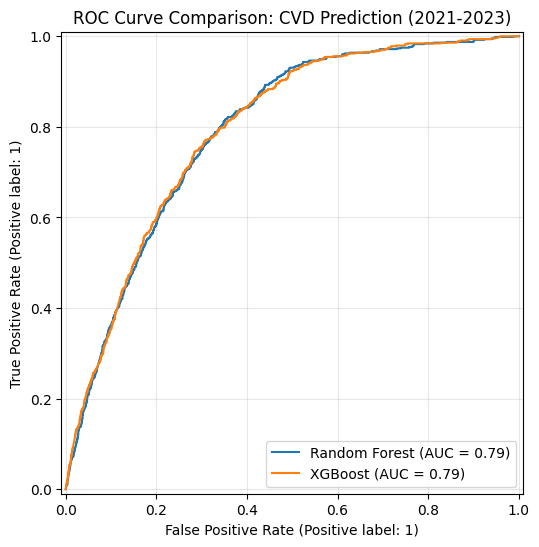

In [15]:
from sklearn.metrics import RocCurveDisplay

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot Random Forest ROC
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=ax, name='Random Forest')

# Plot XGBoost ROC
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax, name='XGBoost')

plt.title('ROC Curve Comparison: CVD Prediction (2021-2023)')
plt.grid(alpha=0.3)
plt.show()

In [23]:
import joblib

# 1. Save the XGBoost Model
joblib.dump(xgb_model, 'cvd_prediction_model_v1.pkl')

# 2. Save your cleaned Master Dataset for future analysis
df_final.to_csv('NHANES_1999_2023_Master_Clean.csv', index=False)

print("Project Assets Saved to 'CVD DATA' folder!")

Project Assets Saved to 'CVD DATA' folder!


In [24]:
# In your Notebook, after running xgb_final.fit(X_train_final, y_train)
import joblib

# Re-save the model that KNOWS about the advanced features
joblib.dump(xgb_final, 'cvd_prediction_model_v2.pkl')

['cvd_prediction_model_v2.pkl']

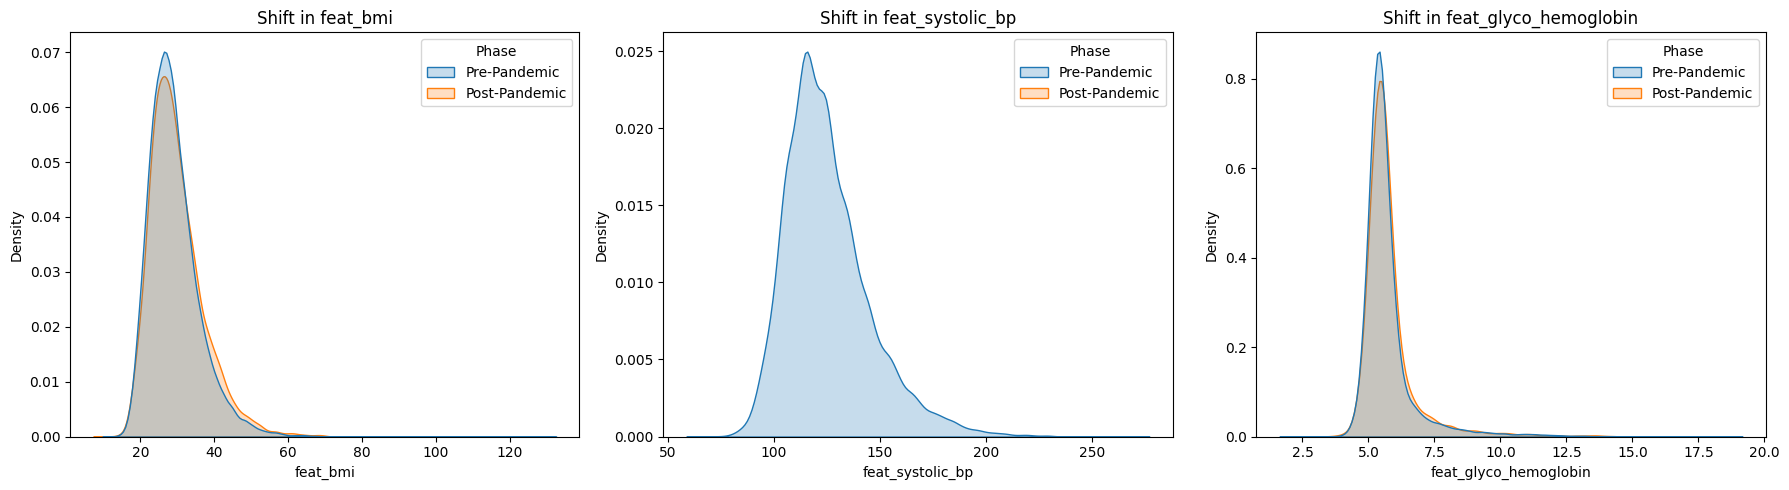

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a 'Phase' column for the plot
df_final['Phase'] = df_final['Cycle_Year'].apply(lambda x: 'Post-Pandemic' if '2021' in x else 'Pre-Pandemic')

features_to_plot = ['feat_bmi', 'feat_systolic_bp', 'feat_glyco_hemoglobin']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(features_to_plot):
    sns.kdeplot(data=df_final, x=feature, hue='Phase', fill=True, ax=axes[i], common_norm=False)
    axes[i].set_title(f'Shift in {feature}')

plt.tight_layout()
plt.show()